In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uber-pickups-summary/UberPickupsSummary (2).csv


# **Part II : Poisson Regression**

In [3]:
# get the data
# transform days values to a range of integers
# transform the hours to one hot encoding 
# tansform the days to a label encoding
# introduce GLM theory
# fit a glm model to the data
# explain the results 
    # explain the p-values of the z-scores
    # explain the deviance test 
    # explain the goodness of fit test
# interpret the coefficients 
# plot the coefficents as a function of the hour and Base
# plot the counts and the predicted values Lambda against the days 
# plot a the Pearson residual against the fitted values
# identify the outliers and the points with high leverage and remove them
# identify what transformed version of the model can make the fit any better if the relationship is not linear
# do a bootstapping validation
    # for every version of the model :
        # fit the model onto 30 resampled subsets
        # get statistics like goodness of fit test values of all the 30 fits
        # draw a box plot of the values 

# make a conclusion about the best model

# fit a deep learning model
# calculate a goodness of fit of deep model

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
Uber = pd.read_csv('/kaggle/input/uber-pickups-summary/UberPickupsSummary (2).csv')
Uber = Uber.drop(columns=['Unnamed: 0'])
Uber

,Base,Date,hour,size
0,B02512,2014-04-01,0,9
1,B02512,2014-04-01,1,4
2,B02512,2014-04-01,2,4
3,B02512,2014-04-01,3,4
4,B02512,2014-04-01,4,9
...,...,...,...,...
21847,B02764,2014-09-30,18,569
21848,B02764,2014-09-30,19,546
21849,B02764,2014-09-30,20,483
21850,B02764,2014-09-30,21,422


In [5]:
encoded_labels, unique_values = pd.factorize(Uber['Date'])
Uber['Date'] = encoded_labels
Uber = pd.get_dummies(Uber, columns=['Base', 'hour']).drop(columns=['hour_0', 'Base_B02512'])
Uber['intercept'] = [1]*len(Uber)
Uber = Uber.astype(np.float32)
Uber

,Date,size,Base_B02598,Base_B02617,Base_B02682,Base_B02764,hour_1,hour_2,hour_3,hour_4,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,intercept
0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21847,182.0,569.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21848,182.0,546.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
21849,182.0,483.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
21850,182.0,422.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# An introduction to Generalize linear models Theorie

In simple linear regression , we regress the dependent variable Y onto the predictors X , using the formula $Y = X.\beta + \epsilon$ , such that Y is real number vector that follow as normal distribution $N(\mu,\sigma)$ and $\beta$ is the coefficients vector that we try to find by minimizing the the error vector $\epsilon$ using Least squares method, thus making the predicted values $X.\beta$ as close as possible to the real Y (i.e $Y \approx X.\beta$ ). 

Sounds great!, it turned out that this method doesn't work well when Y in not real number, this means that Y doesn't follow the normal distribution discribed above, so what can we do ? . To solve this problem we need go a step back to the linear regression problem and make small clarification that we will take as a starting point for our startegie.

When we said that $Y \approx X.\beta$ that was not precise enough,  in reality the correct formula should be $\mu = E[Y|X] \approx X.\beta$
this means that not every point Y is linear with the predictors X , but more precisely it is the conditional mean of Y for each value of X that should be in a linear relationship with X

With that being clarified,  we can start discovering the theoey of Generalized Linear Model "GLM"

**1. Modeling the probability distribution:**
When Y doesn't follow a normal distribution , we need first to figure what distribution it follows , one case is the classification problem where   $Y$ ~ $Bernoulli(p)$, where p is the mean of the distribution, using the idea discribed above about relationship of the mean and the predictors , instead of modeling $Y \approx X.\beta$, we can model 
$p \approx X.\beta$ , but $0 \leq p \leq 1$ ,which means we'll have some problems when modeling it with $X.\beta$  that ranges in $[-\infty, +\infty]$ , so we need to transforme p (or $X.\beta$) so that both sides of the equation can only have values from the same range, and then we model that tranformation as $$transform(p) \approx X.\beta$$.
The tranformation that is used in the classification problem is the one that is known as the **logit** tranformation
$$logit(p) = \log{\frac{p}{1-p}}$$
Solving this equation for p gives us the known activation function **Sigmoid** $$p = sigmoid(X.\beta) = \frac{1}{1+ e^{X.\beta}}$$


**2. Choosing the cost:**
For this kind of problems where we have to transform the linear transformation, using the mean squared error as a cost function often doesn't work because with the transformation , the MSE dosn't satisfy
the condition of convexity and uniquness of the optimum for apply optimization algorithms like Least Sqaures or Gradient Descent

In this situation , it is better to choose cost functions like the Maximum Likelihood Estimator or The Weigted Sqaure Errors

**3. Choosing the optimization algorithm:**
Once the best cost function that satisfies the convexity condition is chosen , its then easy to apply optimization algorithms like SGD, Adam or others 

In [6]:
y = Uber['size']
X = Uber.drop(columns=['size'])
model = sm.GLM(y, X, family = sm.families.Poisson())
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   size   No. Observations:                21852
Model:                            GLM   Df Residuals:                    21847
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.3908e+05
Date:                Thu, 06 Jun 2024   Deviance:                   1.1382e+06
Time:                        06:29:54   Pearson chi2:                 1.29e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Date            0.0036   9.07e-06    398.572      

# Explaining the test results

**1. The Deviance Test:**
The deviance test is analoguous to the F-test in linear regression
The very high values of the deviance $(1.1402*10^6)$ indicates that thers is enough eivdances to reject null hypothesis that $\beta = 0$ and accept the alternative that says that at least one of the coefficents is significantly different than zero


**2. The Z-test:**
The p-values of the z-scores are all lower than $5%$ Which shows that all the coefficents are significantly different than zero

**3. The Pearson $\chi^2$-test:**
This the goodness of fit test that tests how well the actual counts fit the predicted probabilities. $1.30*10^6$ is a large values for this test showing that there is a significant fit between the predicted probabilites and the actual Poisson count random variables in the columns 'size'


# Interpreting the Coefficients

We should be careful when interpreting the results, because an interpretation can differ when the coefficient of a categorical feature from when the feature has real values 

1. Coefficient of date feature:
the date feature in this dataset is an integer value tha can range from $0$ to $+\infty$ which means that our interpretation of the coefficient will the same as we do with a real values feature , in this case we can that $\beta_{Date} = 0.0036$ means that for every one day step to the future we expect an addition of approximitly 0.0036 in $E[Size]$ the expected value of the counts 

2. Coefficent for categorical feature:
When doing one hot encoding tranformation for the categorical features Houre and Base , we dropped two of the resulting features which are Hour_0, and Base_B02512, to keep the transposed matrix fitted by the statmodel lineary independent , because we are adding the intercept , and also those two feature can be considered as base value to interprete the coefficients . For example the coefficient $$\beta_{Base B02598} = 1.9292$$ means that in this base we expect and addition of approximitly 1.9292 in the mean value the counts from the Base_B02512

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Text(0.6944444444444446, 0.5, 'count rate')

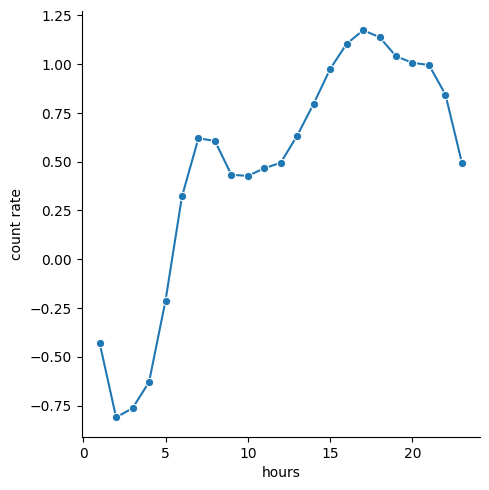

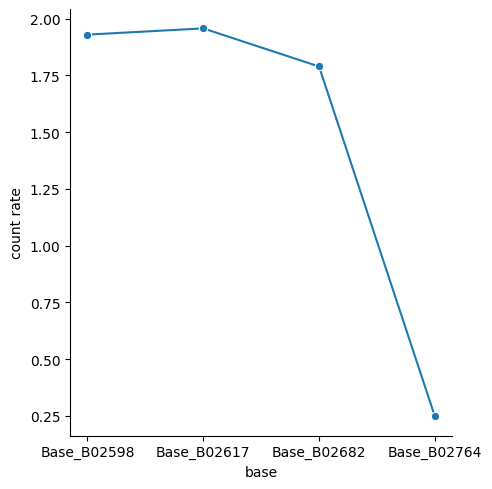

In [7]:
columns = ['hour_'+str(i) for i in range(1,24)]
hour_coefs = results.params[columns]
sns.relplot(x = range(1,24), y= hour_coefs.values, kind='line', marker='o')
plt.xlabel('hours')
plt.ylabel('count rate')
columns = ["Base_B02598", "Base_B02617", "Base_B02682", "Base_B02764"]
Base_coefs = results.params[columns]
sns.relplot(x = columns, y= Base_coefs.values, kind='line', marker='o')
plt.xlabel('base')
plt.ylabel('count rate')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


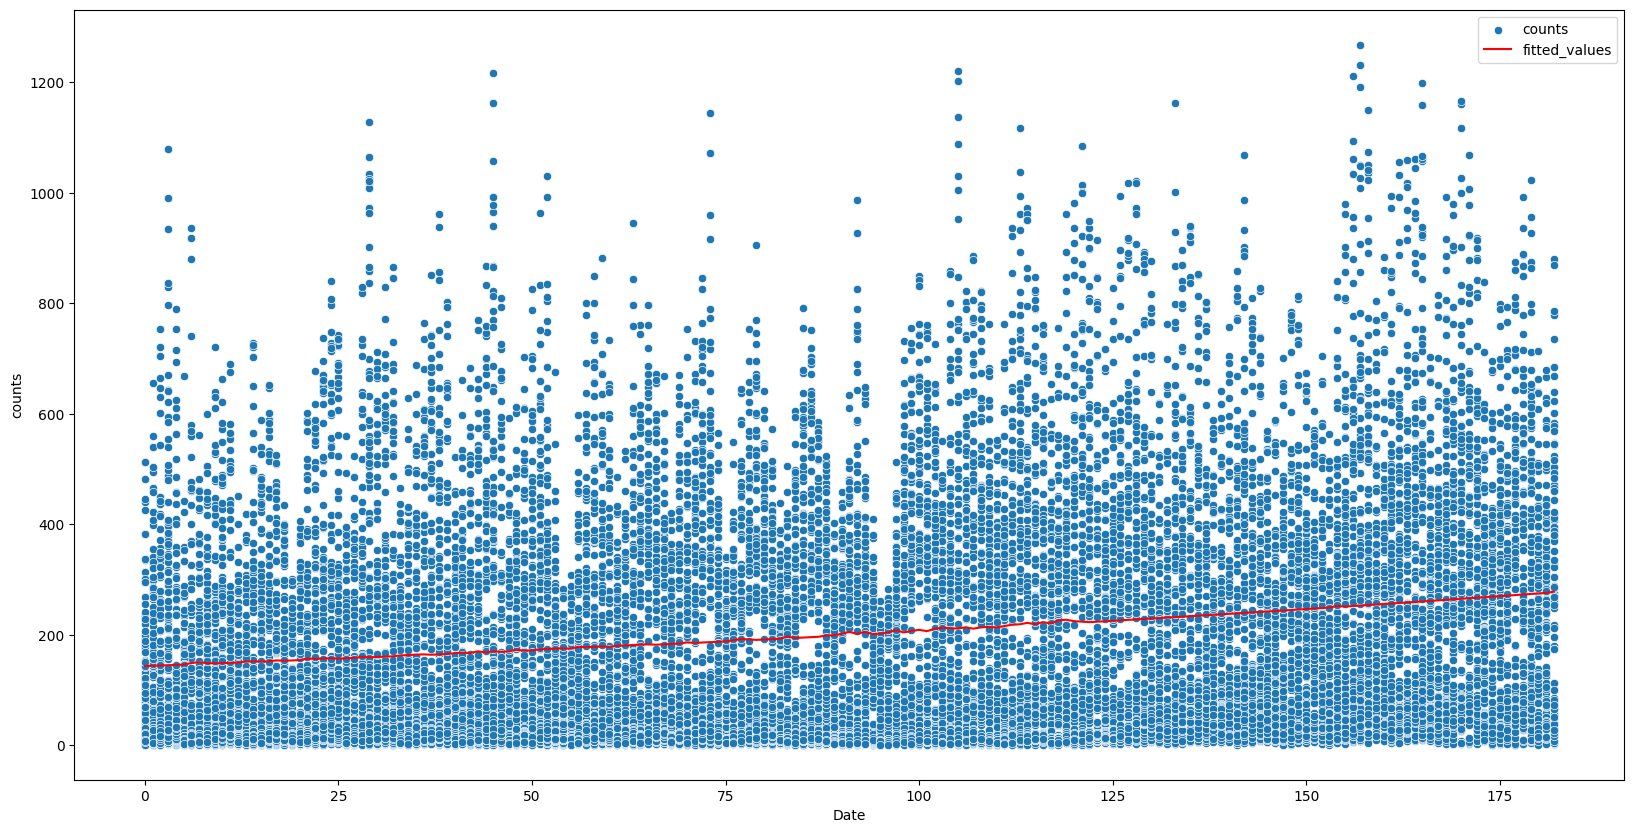

In [8]:
data = pd.DataFrame(results.fittedvalues, columns=['fitted_values'])
data['Date'] = X['Date']
data['counts'] = y.values
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data = data, x = 'Date', y='counts',ax=ax, label='counts')
data_grouped = data.groupby(by='Date').mean()
sns.lineplot(data = data_grouped, x='Date', y='fitted_values',ax=ax ,color='r', label='fitted_values')
plt.legend()

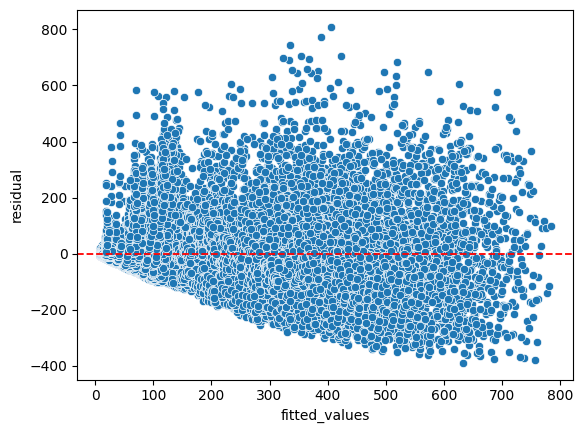

In [9]:
resid = (data['counts'] - data['fitted_values'])
# /np.sqrt(data['fitted_values'])
fig, ax = plt.subplots()
sns.set_theme()
sns.scatterplot(x= data['fitted_values'], y= resid, ax=ax)
ax.set_xlabel('fitted_values')
ax.set_ylabel('residual')
ax.axhline(0, linewidth=1.3, color='red', linestyle='--')

In [10]:
# algorithm
# models_list = [xgboost.XGRegressor, deepNN, SVR, GLM.poisson, KNN(1), KNN(k)]
# train each model on the train set
# generate 30 sample from the test set using bootstrapping 
# test each model in the model list on the 30 samples
# calculate the average chi2 square metric for each model's prediction
# drow a box plot of the calculated chi2 values 
# choose the best model

In [33]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import poisson
from scipy.stats import chisquare
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_set_x, test_set_x, train_set_y, test_set_y=train_test_split(input_data,output_data, test_size=0.2) 



def bootstrap_samples(test_set_x, test_set_y, n_samples):
    """
    Perform bootstrapping on two datasets.

    Parameters:
        test_set_x (array-like): The input data set X.
        test_set_y (array-like): The output data set Y.
        n_samples (int): Number of samples to generate.

    Returns:
        x_samples (list): List of bootstrapped samples from test_set_x.
        y_samples (list): List of bootstrapped samples from test_set_y.
    """

    
    x_samples = []
    y_samples = []

    for _ in range(n_samples):
        # Generate random indices with replacement
        indices = np.random.randint(0, len(test_set_x), len(test_set_x))
        # Create bootstrapped samples for test_set_x and test_set_y
        x_bootstrap = test_set_x[indices] 
        y_bootstrap = test_set_y[indices] 

        # Append the bootstrapped samples to the lists
        x_samples.append(x_bootstrap)
        y_samples.append(y_bootstrap)

    return x_samples, y_samples






def chi_squared_distance(y_pred, y_true):
    """
    Calculate the Chi-squared distance between observed and expected values.

    Parameters:
        y_pred (array-like): Lambda parameter for Poisson distribution.
        y_true (array-like): Observed counts following Poisson distribution.

    Returns:
        chi2_dist (float): Chi-squared distance between observed and expected values.
    """
#     y_pred = y_pred.reshape(-1,1)
#     print(np.sum(y_pred < 0))
#     y_true = y_true.reshape(-1,1)
    
    # Calculate the expected probabilities using y_pred
    expected_probs = poisson.pmf(y_true, y_pred)
#     print(np.sum(np.isnan(expected_probs)))
#     Normalize the expected probabilities
#     expected_probs_normalized = expected_probs / np.sum(expected_probs)
    f_obs = np.ones(y_true.shape)
#     Compute the Chi-squared distance
#     chi2_dist, _ = chisquare(f_obs, f_exp=expected_probs)

    chi2_dist = (f_obs - expected_probs)**2/ expected_probs
    chi2_dist[chi2_dist > 100000] = 100000  
#     score = np.mean(chi2_dist)
#     print(score)
    return chi2_dist




def draw_boxplot(scores_doubly_linked_list, model_names):
    """
    Draw a box plot of scores for different models on different test sets.

    Parameters:
        scores_doubly_linked_list (list): Doubly linked list containing lists of scores.
        model_names (list): Names of the models.

    Returns:
        None
    """
    
    # Flatten the doubly linked list to a list of scores and corresponding model names
    flat_scores = []
    flat_model_names = []
#     print(len(scores_doubly_linked_list))
#     print(len(model_names))
    for i in range(len(scores_doubly_linked_list)):
        for j in range(len(scores_doubly_linked_list[i])):
            flat_scores.append(scores_doubly_linked_list[i][j])
            flat_model_names.append(model_names[i]) 

    # Create a DataFrame from the flattened data
    df = pd.DataFrame({'Model': flat_model_names, 'Score': flat_scores})

    # Draw a box plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model', y='Score', data=df)
    plt.title('Box Plot of Scores for Different Models')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

input_data = Uber.drop(columns=['size']).values
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)
output_data = Uber['size'].values

class PearsonGoodnessOfFit(tf.keras.metrics.Metric):
    def __init__(self, name='pearson chi squared distance', **kwargs):
        super().__init__(name=name, **kwargs)
        self.pearson_goodness_of_fit = self.add_weight(
            shape=(),
            initializer='zeros',
            name='pearson_goodness_of_fit'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        

        if sample_weight is not None:
            pass

        self.pearson_goodness_of_fit.assign(tf.reduce_mean(tf.square(y_true - y_pred)/y_pred))

    def result(self):
        return self.pearson_goodness_of_fit

    
    
    
    
    
deep_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='exponential')
])

deep_model.compile(
    loss = tf.keras.losses.Poisson(),
    metrics = [tf.keras.metrics.MeanSquaredError()],
    optimizer = tf.keras.optimizers.Adam()
)

In [21]:
deep_model.fit(train_set_x, train_set_y, epochs=200, batch_size=5000, validation_split=0.2)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: -82.0972 - mean_squared_error: 83862.1719 - val_loss: -549.4322 - val_mean_squared_error: 73296.7422
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -683.3973 - mean_squared_error: 68004.5156 - val_loss: -622.1374 - val_mean_squared_error: 391265.8438
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: -738.9636 - mean_squared_error: 273268.2500 - val_loss: -899.1882 - val_mean_squared_error: 22124.3242
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -925.5010 - mean_squared_error: 30976.0742 - val_loss: -829.0132 - val_mean_squared_error: 45549.8320
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -864.3035 - mean_squared_error: 49049.1914 - val_loss: -857.9709 - val_mean_squared_error: 36092.5195
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -908.3160 - mean_squared_error: 34456.5234 - val_loss: -896.8814 - val_mean_squared_error: 37356.0977
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [22]:
import xgboost as xgb

# Calculate the mean of the target variable
mean_target = np.mean(train_set_y)

# DMatrix for XGBoost
dtrain = xgb.DMatrix(train_set_x, label=train_set_y)

# Parameters for Poisson regression with properly set base_score
params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',
    'base_score': np.log(mean_target)  # Set base_score to log(mean_target)
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Prediction
# dtest = xgb.DMatrix(test_set_x)
# y_pred = bst.predict(dtest)
# y_pred

Text(0, 0.5, 'score')

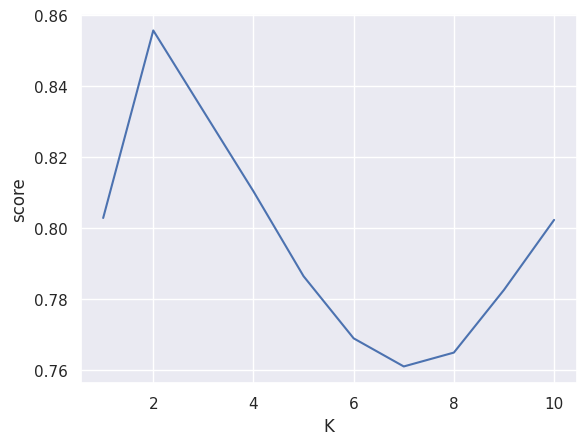

In [31]:
K = range(1, 11)
knn_scores = []
for k in K:
    knnReg = KNeighborsRegressor(n_neighbors=k)
    knnReg.fit(train_set_x, train_set_y)
    knn_scores.append(knnReg.score(test_set_x, test_set_y))
    
plt.plot(K, knn_scores)
plt.xlabel('K')
plt.ylabel('score')

In [24]:
# svr = SVR()
xgb = XGBRegressor(objective='count:poisson', eval_metric='poisson-nloglik', base_score=np.log(mean_target) )
knn_1 = KNeighborsRegressor(n_neighbors=1)
knn_7 = KNeighborsRegressor(n_neighbors=7)

               
#                sm.GLM(train_y, train_X, family = sm.families.Poisson()) ]

# deep_model.fit(train_set_x, train_set_y, epochs = 10, batch_size=1000)
# svr.fit(train_set_x, train_set_y)
xgb.fit(train_set_x, train_set_y)
knn_1.fit(train_set_x, train_set_y)
knn_7.fit(train_set_x, train_set_y)

KNeighborsRegressor(n_neighbors=7)

In [32]:
# import numpy as np
# from sklearn.svm import SVR
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.compose import TransformedTargetRegressor

# # Function to apply exponential transformation
# def exp_transform(x):
#     return np.exp(x)

# # Function to apply log transformation
# def log_transform(x):
#     return np.log(x)

# # Create the pipeline
# pipeline = Pipeline([
#     ('log', FunctionTransformer(func=log_transform, inverse_func=exp_transform, validate=True)),
#     ('svr', SVR(kernel='rbf'))
# ])

# # Transform target variable to ensure positive predictions
# model = TransformedTargetRegressor(regressor=pipeline, func=log_transform, inverse_func=exp_transform)

# # Fit the model
# model.fit(train_set_x, train_set_y)

# # Predict and transform back
# y_pred = model.predict(test_set_x)

# print(y_pred)

In [25]:
test_sets_x, test_sets_y = bootstrap_samples(test_set_x, test_set_y, 10)
print(test_sets_y[2].shape)

(4371,)


In [29]:
models_list = [deep_model, 
#                svr,
               xgb,
               knn_1,
               knn_7]
scores = []
for model in models_list:
    scm = []
    for i in range(len(test_sets_x)):
        y_true = np.array(test_sets_y[i]).reshape(-1,1)
        y_pred = model.predict(test_sets_x[i])
        y_pred = np.array(y_pred).reshape(-1,1)
#         print(np.mean(np.square(y_pred - test_sets_y[i])))
#         scm.append(np.mean(chi_squared_distance(y_pred, y_true)))
        scm.append(np.mean(np.square(y_pred - test_sets_y[i])))
        
    scores.append(scm)
    



137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


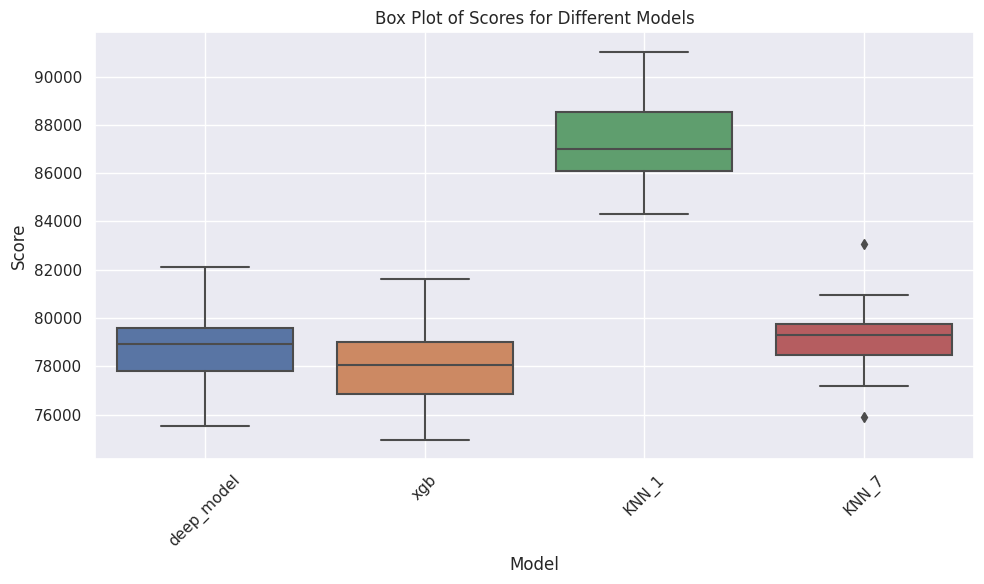

In [30]:
# print(scores)
draw_boxplot(scores ,['deep_model', 'xgb', 'KNN_1', 'KNN_7'])

In [ ]:
# poisson.pmf(1, -1)
xgb.predict(test_sets_x[0])